In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile install.sh
current=$(pwd)

# download boost
wget https://boostorg.jfrog.io/artifactory/main/release/1.77.0/source/boost_1_77_0.tar.gz
tar -xf boost_1_77_0.tar.gz

# install boost
cd boost_1_77_0

./bootstrap.sh --with-libraries=program_options,iostreams
./b2 install

cd $current

Writing install.sh


In [ ]:
!sh install.sh &> /dev/null

In [ ]:
%%writefile install-prereq.sh

# install seqtk
current=$(pwd)
git clone https://github.com/lh3/seqtk.git;
cd seqtk; make

# install wtdbg2
cd $current
git clone https://github.com/ruanjue/wtdbg2
cd wtdbg2 && make

# install seq2vec
cd $current
git clone https://github.com/anuradhawick/seq2vec.git
cd seq2vec
./build.sh

Writing install-prereq.sh


In [ ]:
!sh install-prereq.sh &> /dev/null

In [ ]:
!mkdir test_data
!gdown https://drive.google.com/uc?id=1bvI9YsMDYHMhckAn_zYYvDnhQJ7V8gpR -O test_data/reads.fa
!gdown https://drive.google.com/uc?id=1-KhZzHnkgjwwoHqNlwoF7vr-riaFvonT -O test_data/ground_truth.txt

mkdir: cannot create directory ‘test_data’: File exists
Downloading...
From (original): https://drive.google.com/uc?id=1YU-0rV5pON6Y3MGrHMl4VlykB9QkRatz
From (redirected): https://drive.google.com/uc?id=1YU-0rV5pON6Y3MGrHMl4VlykB9QkRatz&confirm=t&uuid=709d2d35-bcce-4ec3-a97b-8e4d676bc4ae
To: /content/test_data/reads.fa
100% 3.83G/3.83G [00:34<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6mraHxSi3TTrDvMx_40_ulcRQtA6kTV
To: /content/test_data/ground_truth.txt
100% 3.90M/3.90M [00:00<00:00, 179MB/s]


In [ ]:
exp = "./test_data/"

In [ ]:
# !./seqtk/seqtk rename $exp/reads.fastq read_ | ./seqtk/seqtk seq -A > $exp/reads.fasta

In [ ]:
!grep ">" $exp/reads.fa > $exp/read_ids

In [ ]:
!./seq2vec/build/seq2vec -k 4 -o $exp/4mers -f $exp/reads.fa -t 16

Starting Seq2Vec sequence vectorization: TSV output
Counting sequences
179244 sequences found
Completed 100.00%       


In [ ]:
!pip install numpy

In [ ]:
%%writefile filter_alignments.py

import sys
import fileinput
import gzip
import numpy as np

path = "./"

if len(sys.argv) == 2:
    path = sys.argv[1] + "/"

class Alignment:
    def __init__(self, line):
        """
        COL1 qry_name
        COL2 qry_strand
        COL3 qry_length
        COL4 qry_beg
        COL5 qry_end
        COL6 ref_name
        COL7 ref_strand (always equals +)
        COL8 ref_length
        COL9 ref_beg
        COL10 ref_end
        COL11 match_len (length of matched k-mers)
        COL12 align_len (length of aligned)
        COL13 #kcnt (number of matched k-mers)
        COL14 #gap (number of gapped BINs)
        COL15 cigar (256 x SAM's cigar)
        """
        data = line.strip().split("\t")
        self.raw_data = line.strip()
        self.qry_name = data[0]
        self.qry_strand = data[1]
        self.qry_length = int(data[2])
        self.qry_beg = int(data[3])
        self.qry_end = int(data[4])
        self.ref_name = data[5]
        self.ref_strand = data[6]
        self.ref_length = int(data[7])
        self.ref_beg = int(data[8])
        self.ref_end = int(data[9])
        self.match_len = int(data[10])
        self.align_len = int(data[11])
        self.kmers = int(data[12])
        self.gap = int(data[13])


def is_overlap(alignment):
    qry_beg = alignment.qry_beg
    qry_end = alignment.qry_end
    ref_beg = alignment.ref_beg
    ref_end = alignment.ref_end
    qry_length = alignment.qry_length
    ref_length = alignment.ref_length

    THRESHOLD = 512

    # full overlap
    if qry_beg <= THRESHOLD and qry_length - qry_end <= THRESHOLD:
        return True
    elif ref_beg <= THRESHOLD and ref_length - ref_end <= THRESHOLD:
        return True

    # qry end overlap
    if qry_length - qry_end <= THRESHOLD and ref_beg <= THRESHOLD:
        return True
    # ref end overlap
    elif ref_length - ref_end <= THRESHOLD and qry_beg <= THRESHOLD:
        return True

    return False

def process_batch(alignments, fpe, fpd):
    # skip alignments that are self, this can cause total failure
    # skip non overlaps
    alignments = [a for a in alignments if is_overlap(a) and a.qry_name!=a.ref_name]
    # exit if empty (first scenario)
    if len(alignments) == 0:
        return

    # compute alignment overlaps
    alignments = sorted(alignments, key=lambda a: a.match_len, reverse=True)
    match_lengths = [a.match_len for a in alignments]
    mean_match = np.mean(match_lengths)

    degree = 0
    for n, a in enumerate(alignments):
        # record actual edge count
        degree += 1

        # write only top 20 edges
        if n < 20:
            fpe.write(f"{a.qry_name}\t{a.ref_name}\n")

    fpd.write(f"{alignments[0].qry_name}\t{degree}\n")

active_query = None
alns_buffer = []
out_file_edges = open(path + 'reads.alns', 'w+')
out_file_degree = open(path + 'degree', 'w+')

for line in fileinput.input('-'):
    if len(line.strip()) == 1:
        continue

    alignment = Alignment(line)

    if alignment.qry_name != active_query:
        # new query
        # if there is a previous query process it
        if len(alns_buffer) > 0:
            process_batch(alns_buffer, out_file_edges, out_file_degree)
            # sys.exit(0)

        # reset buffers
        active_query = alignment.qry_name
        alns_buffer = [alignment]
    else:
        alns_buffer.append(alignment)

if len(alns_buffer) > 0:
    process_batch(alns_buffer, out_file_edges, out_file_degree)

out_file_edges.close()
out_file_degree.close()

Writing filter_alignments.py


In [ ]:
!./wtdbg2/kbm2  -i $exp/reads.fa -d $exp/reads.fa -n 2000 -l 2560 -t 16 | python filter_alignments.py $exp/

# please refer to chunked version in GitHub for a more memory conservative graph construction.

--
-- total memory       53470760.0 kB
-- available          51584420.0 kB
-- 8 cores
-- Starting program: ./wtdbg2/kbm2 -i ./test_data//reads.fa -d ./test_data//reads.fa -n 2000 -l 2560 -t 16
-- pid                     73604
-- date         Thu Feb  1 13:14:21 2024
--
[Thu Feb  1 13:14:21 2024] loading sequences
179244 reads
[Thu Feb  1 13:14:34 2024] Done, 179244 reads, 3734858266 bp, 14499904 bins
[Thu Feb  1 13:14:34 2024] indexing, 16 threads
[Thu Feb  1 13:14:34 2024] - scanning kmers (K0P21S4.00) from 14499904 bins
14499904 bins
** PROC_STAT(0) **: real 85.147 sec, user 349.470 sec, sys 10.620 sec, maxrss 5176512.0 kB, maxvsize 6551456.0 kB
[Thu Feb  1 13:15:46 2024] - high frequency kmer depth is set to 1000
[Thu Feb  1 13:15:47 2024] - Total kmers = 205083239
[Thu Feb  1 13:15:47 2024] - average kmer depth = 2
[Thu Feb  1 13:15:47 2024] - 0 low frequency kmers (<1)
[Thu Feb  1 13:15:47 2024] - 527 high frequency kmers (>1000)
[Thu Feb  1 13:15:47 2024] - indexing 205082712 kme

In [ ]:
!cp /content/test_data/4mers /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/
!cp /content/test_data/degree /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/
!cp /content/test_data/reads.alns /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/
!cp /content/test_data/read_ids /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/

In [ ]:
!pip install umap-learn
!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=aef5a55463d1295dbcbd88463cf8bd6aff556febd03fb1d422ce74ea986ec1e3
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to /tmp/pip-install-zuckuvh1/hdbscan_be046df5da5640bba0fd1618543159cf
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/hdbscan.git /tmp/pip-install-zuckuvh1/hdbscan_be046df5da5640bba0fd1618543159cf
  Resolved https://github.com/scikit-learn-contrib/hdbscan.git to commit 98928d0c095715edc9584e7989bd8559673bc2f0
  Installing build dependencies ... done
  Getting requirements to build wheel ... d

In [ ]:
! pip install seaborn

In [ ]:
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from  tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd

try:
    from cuml.manifold import UMAP
    from cuml.metrics.cluster.silhouette_score import cython_silhouette_score as silhouette_score
    from cuml.cluster import HDBSCAN
    print('Using CUML')
except Exception as e:
    from sklearn.metrics import silhouette_score
    from umap import UMAP
    from hdbscan import HDBSCAN
    print('Using SciPy', e)

Using SciPy No module named 'cuml'


In [ ]:
exp = "./test_data/"

alignments_file_path = exp + "reads.alns"
degrees_file_path = exp + "degree"

comp = pd.read_csv(exp + "4mers", header=None).to_numpy()

try:
    truth = np.array(open(exp + "ground_truth.txt").read().strip().split("\n"))
except:
    truth = np.array([str(0) for x in range(len(comp))])
reads = exp + "reads.fa"

In [ ]:
!wc -l $exp/read_ids

179244 ./test_data//read_ids


In [ ]:
!wc -l $exp/degree

177746 ./test_data//degree


In [ ]:
!wc -l $exp/ground_truth.txt

179244 ./test_data//ground_truth.txt


In [ ]:
!wc -l $exp/4mers

179244 ./test_data//4mers


In [ ]:
truth.shape

(179244,)

In [ ]:
!grep -c '>' $exp/reads.fa

179244


In [ ]:
# read_id_idx = {}

def get_palette(labels):
    palette = {x: f'C{n}' for n, x in enumerate(sorted(set(labels) - {-1, '-1', 'Unknown', 'unknown'}))}
    palette['Unknown'] = 'white'
    palette['-1'] = 'white'
    palette[-1] = 'white'

    return palette


def get_idx_maps(read_ids_file_path, truth):
    reads_truth = {}
    read_id_idx = {}
    # global read_id_idx
    with open(read_ids_file_path) as read_ids_file:
        for t, rid in tqdm(zip(truth, read_ids_file)):
            rid = rid.strip().split()[0][1:]
            reads_truth[rid] = t
            read_id_idx[rid] = len(read_id_idx)

    return reads_truth, read_id_idx


def load_read_degrees(degrees_file_path,read_id_idx):
    degree_array = np.zeros_like(truth, dtype=int)
    for line in tqdm(open(degrees_file_path, 'r')):
        i, d = line.strip().split()
        d = int(d)
        # print(degree_array)
        degree_array[read_id_idx[i]] = d

    return degree_array


def alignments_to_edges(alignments_file_path, edges_txt_path, read_id_idx, reads_truth):
    TP = 0
    FP = 0

    if not os.path.isfile(edges_txt_path):
        with open(edges_txt_path, "w+") as ef:
            for line in tqdm(open(alignments_file_path, "r")):
                u, v = line.strip().split('\t')

                if u == v:
                    continue
                try:
                    ef.write(f"{read_id_idx[u]}\t{read_id_idx[v]}\n")

                    if reads_truth[u] == 'Unknown' or reads_truth[v] == 'Unknown':
                        continue
                    if reads_truth[u] == reads_truth[v]:
                        TP += 1
                    else:
                        FP += 1
                except:
                    print(f'Missing {u,v}')
    return TP, FP


def load_edges_as_numpy(edges_txt_path, edges_npy_path):
    if not os.path.isfile(edges_npy_path):
        edges_txt = [x.strip() for x in tqdm(open(edges_txt_path))]
        edges = np.zeros((len(edges_txt), 2), dtype=np.int32)

        for i in tqdm(range(len(edges_txt))):
            e1, e2 = edges_txt[i].strip().split()
            edges[i]  = [int(e1), int(e2)]

        np.save(edges_npy_path, edges)

    return np.load(edges_npy_path)


def plot_degree_hist(degree, path=None):
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 16})

    sns.histplot(degree_array[degree_array>1], binwidth=5) # it must be more than 1 (can have self edges)
    plt.ylabel('No. of Vertices', fontsize=18)
    plt.xlabel('Degree', fontsize=18)

    if path is not None:
        plt.savefig(path, dpi=1200, bbox_inches = 'tight')
    else:
        plt.show()


def plot_umap(embedding, labels, palette=None, path=None, paper=False):
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('UMAP 2', fontsize=18)
    plt.xlabel('UMAP 1', fontsize=18)

    if path is not None and not paper:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.savefig(path, dpi=1200, bbox_inches = 'tight')
    if path is not None and paper:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette, legend=False)
        plt.savefig(path.replace('.pdf', '-paper.pdf'), dpi=1200, bbox_inches = 'tight')
    else:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")


def get_highest_scoring_clustering(data, size):
    best_score = -1
    best_clusters = None
    best_size = -1

    try:
        clusters = HDBSCAN(min_cluster_size=size).fit_predict(data)
        if len(set(clusters) - {1}) == 0:
            return None, -1, None
        score = silhouette_score(data[clusters!=-1], clusters[clusters!=-1])

        print(size, score)
    except:
        pass

    if score > best_score:
        best_score = score
        best_clusters = clusters
        best_size = size

    return best_size, best_score, best_clusters


def get_best_embedding(data, weights):
    best_size = None
    best_sample_size = None
    best_sample_idx = None
    best_score = -1
    best_clusters = None
    best_embedding = None
    best_cluster_count = None

    for sample_size in [25000, 50000, 100000]:
        print(f'Scanning sample size {sample_size}')
        sample_idx = np.random.choice(range(len(data)), size=sample_size, replace=False, p=weights/weights.sum())
        sampled_data = data[sample_idx]
        embedding = UMAP().fit_transform(sampled_data)
        size, score, clusters = get_highest_scoring_clustering(embedding, 500)
        count = len(set(clusters) - {-1})

        print(f'Cluster size = {size:5} Clusters = {count:5} Score = {score:1.5f}')

        if score > best_score:
            best_cluster_count = count
            best_size = size
            best_sample_size = sample_size
            best_score = score
            best_clusters = clusters
            best_embedding = embedding
            best_sample_idx = sample_idx

    return best_size, best_sample_size, best_score, best_clusters, best_cluster_count, best_embedding, best_sample_idx


def rename_clusters(clusters):
    rename_map = {k:n for n, k in enumerate(set(clusters) - {-1})}
    rename_map[-1] = -1

    clusters = np.array([rename_map[x] for x in clusters])

    return clusters

179244it [00:00, 379056.80it/s]
177746it [00:00, 773004.95it/s]
3412328it [00:10, 324445.10it/s]


Precision of reads (if ground truth provided) 99.05272881124249


3412328it [00:01, 2221385.63it/s]
100%|██████████| 3412328/3412328 [00:04<00:00, 785587.61it/s]


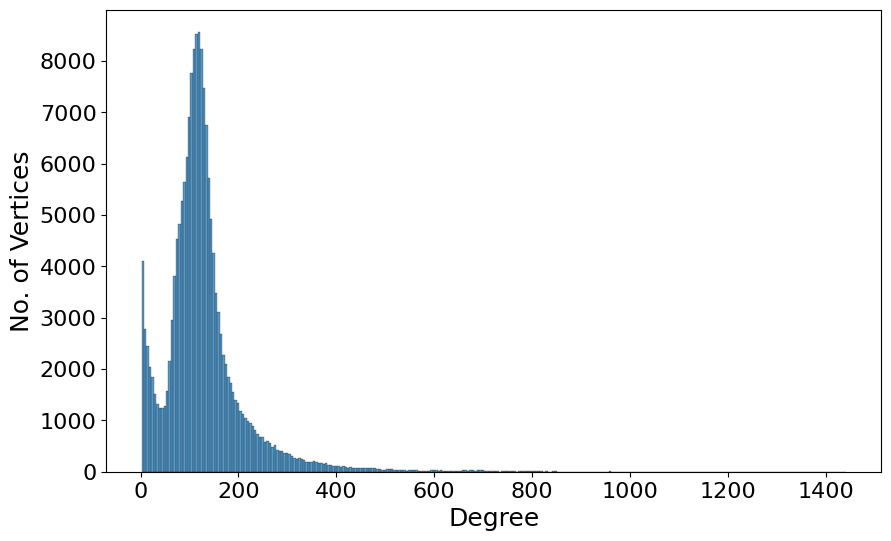

In [ ]:
palette = get_palette(truth)
reads_truth, read_id_idx = get_idx_maps(exp + 'read_ids', truth)
degree_array = load_read_degrees(degrees_file_path,read_id_idx)
TP, FP = alignments_to_edges(alignments_file_path, exp + "edges.txt", read_id_idx, reads_truth)

print("Precision of reads (if ground truth provided)", 100 * TP/ (TP+FP + 1e-5))

edges = load_edges_as_numpy(exp + "edges.txt", exp + "edges.npy")
sample_weights = np.zeros_like(degree_array, dtype=np.float32)
sample_scale = np.ones_like(degree_array, dtype=np.float32)

plot_degree_hist(degree_array)

In [ ]:
truth.shape

(179244,)

In [ ]:
for n, d in enumerate(degree_array):
    sample_weights[n] = 1.0/d if d>0 else 0
    sample_scale[n] = max(1, np.log10(max(1, d)))

scaled = comp * sample_scale.reshape(-1, 1)

In [ ]:
results = []

for i in range(5):
    t_size, t_sample_size, t_score, t_clusters, t_cluster_count, t_embedding, t_sample_idx = get_best_embedding(scaled, sample_weights)

    results.append([t_size, t_sample_size, t_score, t_clusters, t_cluster_count, t_embedding, t_sample_idx])

Scanning sample size 25000
500 0.68915075
Cluster size =   500 Clusters =    10 Score = 0.68915
Scanning sample size 50000
500 0.59802157
Cluster size =   500 Clusters =     8 Score = 0.59802
Scanning sample size 100000
500 0.6181284
Cluster size =   500 Clusters =    11 Score = 0.61813
Scanning sample size 25000
500 0.68153507
Cluster size =   500 Clusters =    11 Score = 0.68154
Scanning sample size 50000
500 0.66587394
Cluster size =   500 Clusters =    12 Score = 0.66587
Scanning sample size 100000
500 0.6147918
Cluster size =   500 Clusters =    12 Score = 0.61479
Scanning sample size 25000
500 0.71218014
Cluster size =   500 Clusters =    10 Score = 0.71218
Scanning sample size 50000
500 0.6651241
Cluster size =   500 Clusters =    12 Score = 0.66512
Scanning sample size 100000
500 0.59902686
Cluster size =   500 Clusters =    10 Score = 0.59903
Scanning sample size 25000
500 0.6729044
Cluster size =   500 Clusters =    10 Score = 0.67290
Scanning sample size 50000
500 0.674044
C

In [ ]:
size, sample_size, score, clusters, cluster_count, embedding, sample_idx = None, None, -1, None, 0, None, None

cluster_counts = Counter([result[4] for result in results])
cluster_counts = sorted(cluster_counts.most_common(), key=lambda x: (x[1], x[0]), reverse=True)
chose = cluster_counts[0][0]

print(f"Count stats = {cluster_counts}")
print(f'Maximally occuring cluster count = {chose}')

for result in results:
    if result[4] == chose and result[2] > score:
        size, sample_size, score, clusters, cluster_count, embedding, sample_idx = result

Count stats = [(11, 2), (10, 2), (12, 1)]
Maximally occuring cluster count = 11


In [ ]:
print(f'Chosen Score = {score:3.4f} Sample_size = {sample_size:5} Size = {size} Clusters = {cluster_count}')

Chosen Score = 0.6869 Sample_size = 25000 Size = 500 Clusters = 11


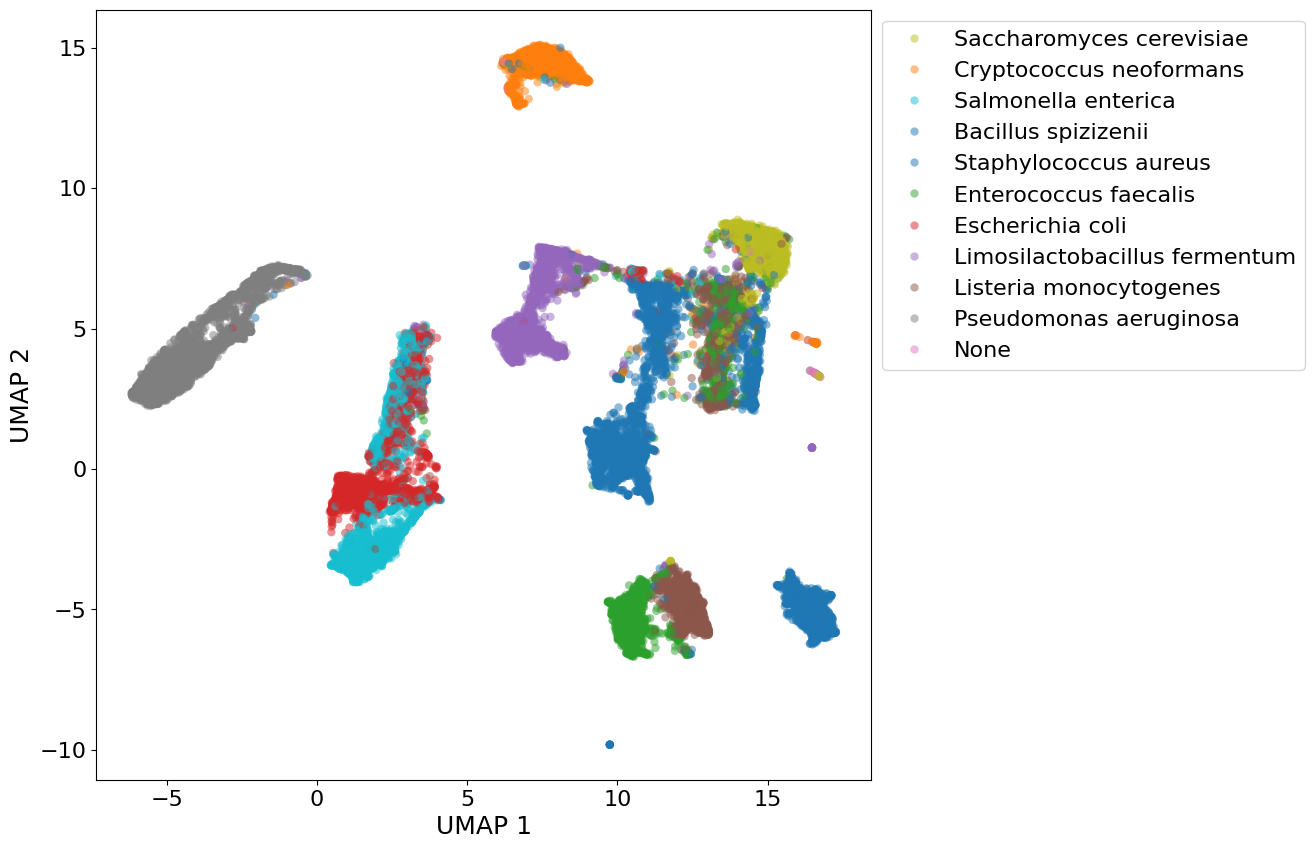

In [ ]:
plot_umap(embedding, truth[sample_idx], palette)

In [ ]:
clusters = rename_clusters(clusters)

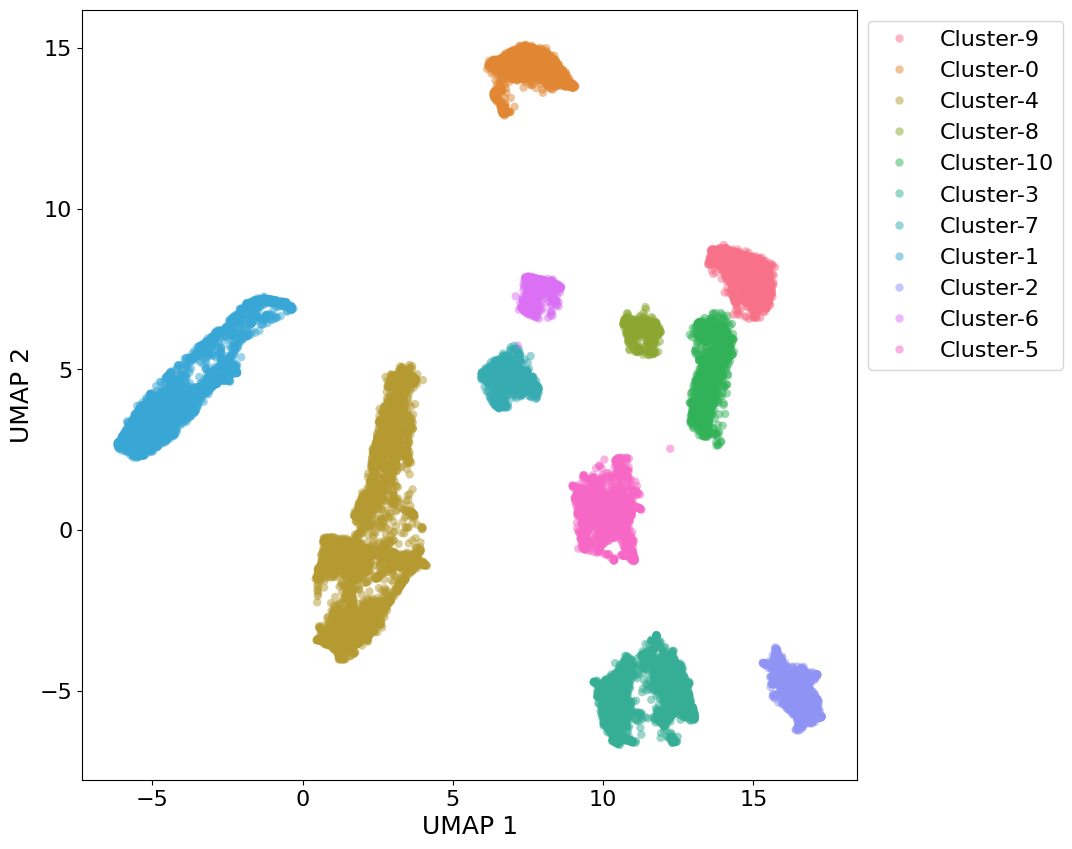

In [ ]:
plot_umap(embedding[clusters!=-1], [f"Cluster-{x}" for x in clusters[clusters!=-1]])

In [ ]:
read_cluster = np.array([[r, c] for r, c in zip(sample_idx, clusters) if c!=-1])

In [ ]:
np.savez(exp + 'data.npz', edges=edges, scaled=scaled, read_cluster=read_cluster)

In [ ]:
!cp /content/test_data/edges.npy /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/
!cp /content/test_data/edges.txt /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/
!cp /content/test_data/data.npz /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/

<h1>Step 5</h1>

In [ ]:
# !mkdir test_data

In [ ]:
# !cp /content/drive/MyDrive/test_data_zymo/data.npz /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/degree /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/edges.npy /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/edges.txt /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/ground_truth.txt /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/read_ids /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/reads.alns /content/test_data
# !cp /content/drive/MyDrive/test_data_zymo/4mers /content/test_data

In [ ]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
import torch

In [ ]:
!python --version

Python 3.10.12


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
tv = torch.__version__
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-"$tv".html
!pip install biopython

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.2 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data, Dataset
from torch_geometric.data import NeighborSampler
from torch_cluster import random_walk

import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

In [ ]:
truth = np.array(open(exp + "ground_truth.txt").read().strip().split("\n"))
data = np.load(exp + 'data.npz')

In [ ]:
edges = data['edges']
comp = data['scaled']
read_cluster = data['read_cluster']

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, device):
        super(SAGE, self).__init__()

        self.num_layers = num_layers
        hidden_channels = (in_channels + out_channels)//2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

        self.device = device

        self.to(device)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]
            x = self.convs[i]((x, x_target), edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.2, training=self.training)

        x = self.fc1(x)
        embedding = x
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.fc2(x)

        return x.log_softmax(dim=-1), embedding

    def inference(self, x_all, subgraph_loader):
        idx = []

        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                if i==0:
                    idx += list(n_id[:batch_size].numpy())
                edge_index, _, size = adj.to(self.device)
                x = x_all[n_id].to(self.device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                x = F.relu(x)
                xs.append(x)

            x_all = torch.cat(xs, dim=0)

        x = self.fc1(x_all)
        x = F.relu(x)
        x = self.fc2(x)

        x = x.cpu()

        return np.array(idx), x

In [ ]:
def train(model, x, y, optimizer, train_loader, device):
    model.train()
    total_loss = 0

    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()
        out, embd = model(x[n_id], adjs)

        loss = F.nll_loss(out, y[n_id[:batch_size]])

        loss.backward()
        optimizer.step()

        total_loss += float(loss)

    loss = total_loss / len(train_loader)

    return loss


@torch.no_grad()
def test(model, x, subgraph_loader):
    model.eval()

    out = model.inference(x, subgraph_loader)
    return out

In [ ]:
def get_graph_data(features, edges):
    edge_index = torch.tensor(edges, dtype=torch.long)
    data = Data(x=torch.tensor(features).float(), edge_index=edge_index.t().contiguous())

    return data

data = get_graph_data(comp, edges)

In [ ]:
def get_train_data(features, read_cluster):
    train_idx = read_cluster.T[0]
    train_idx = torch.LongTensor(train_idx)

    y = -1 * torch.ones(len(features), dtype=torch.long)
    y[train_idx] = torch.LongTensor(read_cluster.T[1])
    no_classes = len(set(read_cluster.T[1]))

    return train_idx, y, no_classes

train_idx, y, no_classes = get_train_data(comp, read_cluster)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.x.shape[1], no_classes, 2, device)

In [ ]:
print("Using the device", device)

Using the device cpu


In [ ]:
print("Model summary\n-------------\n", model, "\n-------------")

Model summary
-------------
 SAGE(
  (convs): ModuleList(
    (0): SAGEConv(136, 73, aggr=mean)
    (1): SAGEConv(73, 73, aggr=mean)
  )
  (fc1): Linear(in_features=73, out_features=73, bias=True)
  (fc2): Linear(in_features=73, out_features=11, bias=True)
) 
-------------


In [ ]:
train_loader = NeighborSampler(data.edge_index,
                               node_idx=train_idx,
                               sizes=[50, 50],
                               batch_size=64,
                               pin_memory=True,
                               shuffle=True,
                               drop_last=True,
                               num_workers=2)

subgraph_loader = NeighborSampler(data.edge_index,
                                  node_idx=None,
                                  sizes=[-1],
                                  pin_memory=True,
                                  batch_size=10240,
                                  shuffle=False,
                                  num_workers=2)

In [ ]:
x = data.x.to(device)
y = y.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=10e-6)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

epochs = 100

# for plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-1, 201)
ax.set_ylim(0, 1)
plt.ion()
fig.show()
fig.canvas.draw()
losses = []
prev_loss = 100

for epoch in range(1, epochs+1):
    loss = train(model, x, y, optimizer, train_loader, device)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')
    dloss = prev_loss-loss
    prev_loss = loss
    # plot params
    losses.append(loss)
    ax.clear()
    ax.plot(losses)
    ax.set_xlim(-1, 101)
    ax.set_ylim(0, 1)
    fig.canvas.draw()

    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}', end="\r", flush=True)

    if loss < 0.05:
        print()
        print('Early stopping, loss less than 0.05')
        break

print()

<IPython.core.display.Javascript object>

Epoch 01, Loss: 1.3714
Epoch 02, Loss: 0.5338
Epoch 03, Loss: 0.4031
Epoch 04, Loss: 0.3355
Epoch 05, Loss: 0.2852
Epoch 06, Loss: 0.2424
Epoch 07, Loss: 0.2072
Epoch 08, Loss: 0.1772
Epoch 09, Loss: 0.1522
Epoch 10, Loss: 0.1348
Epoch 11, Loss: 0.1206
Epoch 12, Loss: 0.1095
Epoch 13, Loss: 0.0991
Epoch 14, Loss: 0.0937
Epoch 15, Loss: 0.0856
Epoch 16, Loss: 0.0765
Epoch 17, Loss: 0.0750
Epoch 18, Loss: 0.0754
Epoch 19, Loss: 0.0647
Epoch 20, Loss: 0.0617
Epoch 21, Loss: 0.0603
Epoch 22, Loss: 0.0584
Epoch 23, Loss: 0.0579
Epoch 24, Loss: 0.0543
Epoch 25, Loss: 0.0520
Epoch 26, Loss: 0.0516
Epoch 27, Loss: 0.0482

Early stopping, loss less than 0.05



In [ ]:
# we must keep track of classified ids, since lonely nodes are not classified
idx, preds = test(model, x, subgraph_loader)

In [ ]:
classes = torch.argmax(preds, axis=1)
np.savez(exp +'classes.npz', classes=classes.numpy(), classified=idx)

In [ ]:
classification = np.load(exp + 'classes.npz')

classes = classification['classes']
idx = classification['classified']
no_classes = len(set(classes))
spec_set = set(truth) - {'Unknown'}


matrix = np.zeros((len(spec_set), no_classes))
spec_idx = {s:n for n, s in enumerate(spec_set)}
idx_spec = {n:s for n, s in enumerate(spec_set)}

for n, (c, t) in tqdm(enumerate(zip(classes, truth[idx]))):
    if t == 'Unknown':
        continue
    matrix[spec_idx[t], c] += 1

tot = matrix.sum()
row_sum = matrix.max(0).sum()
col_sum = matrix.max(1).sum()

print(matrix.shape)
p, r = 100*row_sum/tot, 100*col_sum/tot
f1 = 2 * p * r / (p + r)

print(f'Precision  =  {p:3.2f}')
print(f'Recall     =  {r:3.2f}')
print(f'F1-score   =  {f1:3.2f}')

179244it [00:00, 638894.55it/s]

(11, 11)
Precision  =  73.25
Recall     =  93.82
F1-score   =  82.27


In [ ]:
!cp /content/test_data/classes.npz /content/drive/MyDrive/FYP/FYP/datasets/ZymoEVEN/v2/